In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

# Parameters
IMG_SIZE = 128
CLASSES = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
NUM_CLASSES = len(CLASSES)
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/hand_data/data"

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Load and preprocess data
def load_data():
    images, labels = [], []
    for label, class_name in enumerate(CLASSES):
        class_path = os.path.join(DATASET_PATH, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(label)

    images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
    labels = np.array(labels)
    return train_test_split(images, labels, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = load_data()

# Improved CNN Model
def create_improved_model():
    model = keras.Sequential([
        data_augmentation,

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.5),

        # Classifier
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_improved_model()

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

# Save the final model
model.save("hand_sign_model_deepseek.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


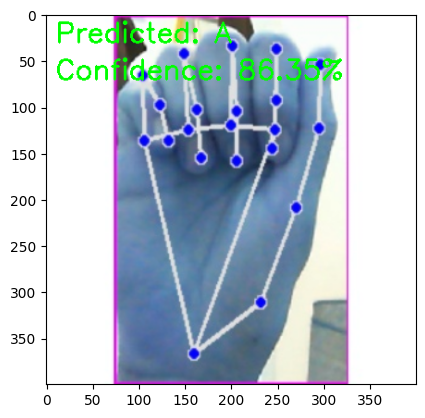

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Parameters (must match training settings)
IMG_SIZE = 128
CLASSES = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/hand_data/model/hand_sign_model_deepseek.h5")

def preprocess_image(img_path):
    """Load and preprocess an image for prediction."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if img is None:
        raise ValueError(f"Image not found at {img_path}")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to match training
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1) / 255.0  # Add batch dim and normalize
    return img

def predict_image(img_path):
    """Predict the class of a single image."""
    img = preprocess_image(img_path)
    pred = model.predict(img)
    predicted_class = CLASSES[np.argmax(pred)]
    confidence = np.max(pred) * 100
    return predicted_class, confidence

def test_on_single_image(img_path):
    """Test the model on a single image and display results."""
    predicted_class, confidence = predict_image(img_path)

    # Display the image with prediction
    img_display = cv2.imread(img_path)
    img_display = cv2.resize(img_display, (400, 400))
    cv2.putText(img_display, f"Predicted: {predicted_class}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(img_display, f"Confidence: {confidence:.2f}%", (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    plt.imshow( img_display)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    img_path = "/content/drive/MyDrive/Colab Notebooks/hand_data/data/TEST/test1.jpg"
    test_on_single_image(img_path)